## Library

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.utils as image
import os

## Read in the data

In [3]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/train',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/test',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/valid',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

Found 1296 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 124 files belonging to 2 classes.


Find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [4]:
class_names = train_set.class_names
print(class_names)

['A', 'S']


Here are the random nine images from the training dataset:

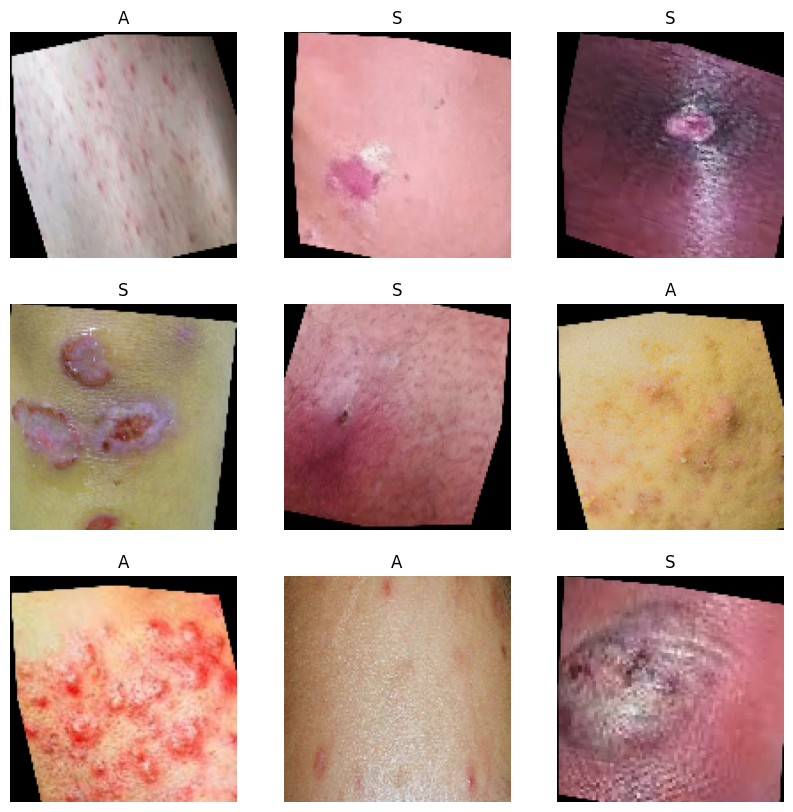

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

According to tf.keras.utils.image_dataset_from_directory document, labels should be sorted according to the alphanumeric order of the image file paths so: 

* Class A : 0

* Class S : 1

In [6]:
#The labels should match the smple images showed above
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0])>

Check number of images for each class.

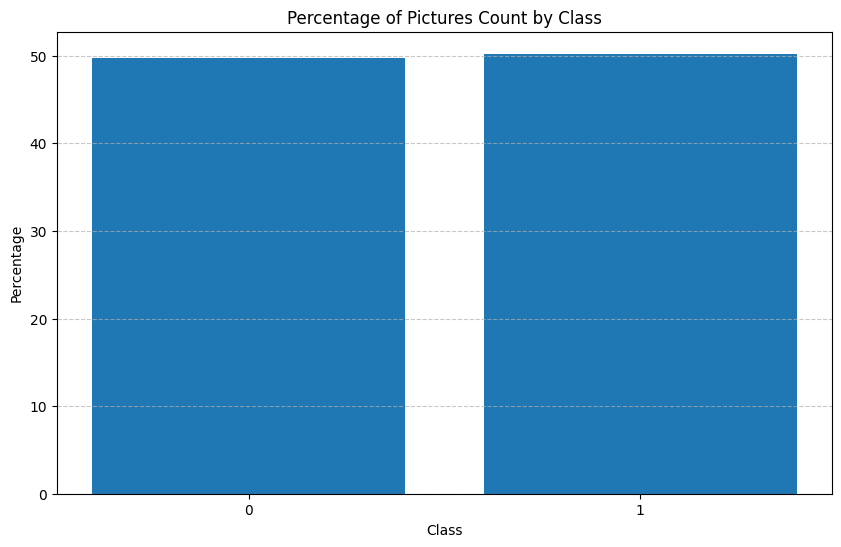

In [7]:
class_count_train = {}
for images, labels in train_set:
    for label in labels.numpy():
        if label not in class_count_train :
            class_count_train [label] = 1
        else:
            class_count_train [label] += 1

class_counts_df_train = {}

for images, labels in train_set:
    for label in labels.numpy():
        class_count_train[label] = class_count_train.get(label, 0) + 1
    
class_counts_df_train = pd.DataFrame(class_count_train .items(), columns=["Class", "Pictures Count"])

total_pictures = class_counts_df_train['Pictures Count'].sum()

# Calculate the percentage for each class and add it as a new column
class_counts_df_train['Percentage'] = (class_counts_df_train['Pictures Count'] / total_pictures) * 100

plt.figure(figsize=(10, 6))
plt.bar(class_counts_df_train['Class'], class_counts_df_train['Percentage'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Percentage of Pictures Count by Class')
plt.xticks(class_counts_df_train['Class'])  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

This is a batch of 32 images of shape 128x128x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [8]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


To enhance the performance

* train.cache(): Caches the elements of the dataset, which can improve the training speed by avoiding redundant data loading.

* .shuffle(1000): Shuffles the elements of the dataset with a buffer size of 1000. This randomizes the order of the data, which is beneficial during training.

* .prefetch(buffer_size=AUTOTUNE): Prefetches elements from the dataset to overlap the data loading and model execution. The buffer_size is set to the AUTOTUNE constant, allowing TensorFlow to determine an optimal value for parallelism.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

## Modeling

### Baseline Model

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)), # Standardize the data, the pixel values are now in `[0,1]`
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [14]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


41/41 [==============================] - 5s 110ms/step - loss: 0.6900 - accuracy: 0.5648 - val_loss: 0.6592 - val_accuracy: 0.6371
Epoch 2/50
41/41 [==============================] - 5s 112ms/step - loss: 0.6271 - accuracy: 0.6427 - val_loss: 0.6655 - val_accuracy: 0.6129
Epoch 3/50
41/41 [==============================] - 5s 110ms/step - loss: 0.5804 - accuracy: 0.6705 - val_loss: 0.6221 - val_accuracy: 0.6048
Epoch 4/50
41/41 [==============================] - 5s 112ms/step - loss: 0.5560 - accuracy: 0.7160 - val_loss: 0.5743 - val_accuracy: 0.7177
Epoch 5/50
41/41 [==============================] - 4s 109ms/step - loss: 0.5293 - accuracy: 0.7276 - val_loss: 0.5759 - val_accuracy: 0.7419
Epoch 6/50
41/41 [==============================] - 5s 111ms/step - loss: 0.5241 - accuracy: 0.7415 - val_loss: 0.5318 - val_accuracy: 0.7661
Epoch 7/50
41/41 [==============================] - 5s 112ms/step - loss: 0.4830 - accuracy: 0.7739 - val_loss: 0.6557 - val_accuracy: 0.6855
Epoch 8/50
41/41 

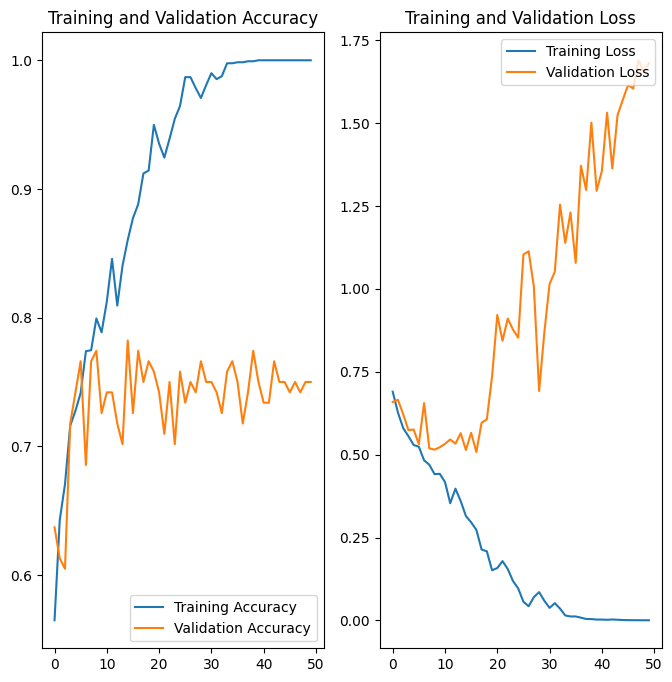

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()